# Import Packages

In [24]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
print(tf.__version__)


2.5.0


# Utility Packages

In [4]:
def plotSeries(time, series, format="-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def trend(time, slope=0 ):
    return slope* time

In [6]:
def seasonalPattern(seasonTime):
    return np.where(seasonTime < 0.4, np.cos(seasonTime * 2 * np.pi), 1/np.exp(3*seasonTime))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    seasonTime = ((time + phase) % period) / period
    return amplitude * seasonalPattern(seasonTime)

In [8]:
def noise(time, noiseLevel = 1, seed=99):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noiseLevel

In [9]:
def windowDataset(series, windowSize, batchSize, shuffleBuffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(windowSize + 1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(windowSize + 1))
    dataset = dataset.shuffle(shuffleBuffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batchSize).prefetch(1)
    return dataset

# The Series

In [10]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
amplitude = 40
noiseLevel = 5
slope = 0.05

In [11]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude = amplitude)
series+= noise(time, noiseLevel)

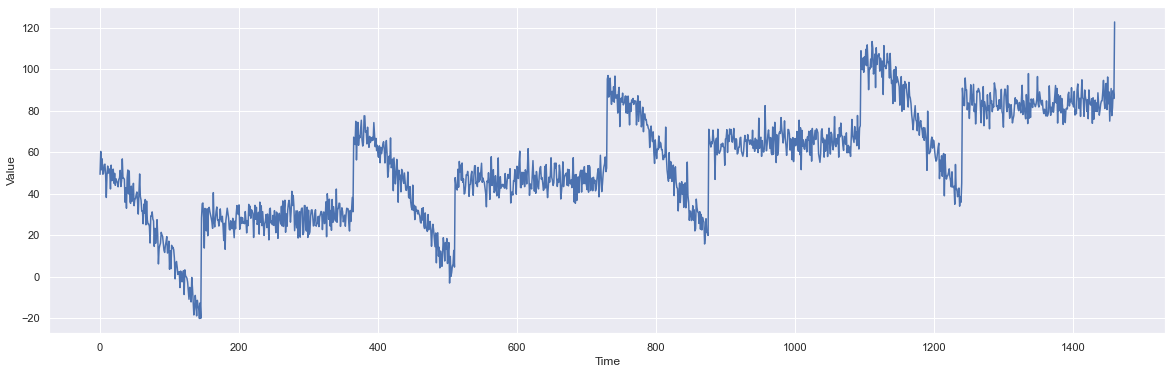

In [12]:
plt.figure(figsize=(20, 6))
plotSeries(time, series)
plt.show()

## The Split

In [13]:
splitTime = 1000
timeTrain = time[:splitTime]
xTrain = series[:splitTime]
timeValid = time[splitTime:]
xValid = series[splitTime:]

# Training Field

In [14]:
windowSize = 20
batchSize = 32
shuffleBufferSize = 1000

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [36]:
trainSet = windowDataset(xTrain, windowSize, batchSize, shuffleBufferSize)

## Model - Single LSTM Layer

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [18]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [20]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

Epoch 1/500
31/31 [==============================] - 4s 19ms/step - loss: 12.8557 - mae: 13.3470
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 12.7341 - mae: 13.2253
Epoch 3/500
31/31 [==============================] - 0s 11ms/step - loss: 12.6106 - mae: 13.1016
Epoch 4/500
31/31 [==============================] - 0s 11ms/step - loss: 12.4993 - mae: 12.9898
Epoch 5/500
31/31 [==============================] - 0s 11ms/step - loss: 12.3949 - mae: 12.8846
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 12.3046 - mae: 12.7923
Epoch 7/500
31/31 [==============================] - 0s 11ms/step - loss: 12.2194 - mae: 12.7065
Epoch 8/500
31/31 [==============================] - 0s 12ms/step - loss: 12.1434 - mae: 12.6313
Epoch 9/500
31/31 [==============================] - 0s 11ms/step - loss: 12.0751 - mae: 12.5649
Epoch 10/500
31/31 [==============================] - 0s 10ms/step - loss: 12.0128 - mae: 12.5044
Epoch 11/500
31/31 [=========

31/31 [==============================] - 0s 11ms/step - loss: 9.9706 - mae: 10.4617
Epoch 85/500
31/31 [==============================] - 0s 11ms/step - loss: 9.9437 - mae: 10.4349
Epoch 86/500
31/31 [==============================] - 0s 11ms/step - loss: 9.9157 - mae: 10.4067
Epoch 87/500
31/31 [==============================] - 0s 11ms/step - loss: 9.8879 - mae: 10.3788
Epoch 88/500
31/31 [==============================] - 0s 11ms/step - loss: 9.8588 - mae: 10.3495
Epoch 89/500
31/31 [==============================] - 0s 11ms/step - loss: 9.8311 - mae: 10.3215
Epoch 90/500
31/31 [==============================] - 0s 11ms/step - loss: 9.8018 - mae: 10.2920
Epoch 91/500
31/31 [==============================] - 0s 11ms/step - loss: 9.7725 - mae: 10.2623
Epoch 92/500
31/31 [==============================] - 0s 12ms/step - loss: 9.7429 - mae: 10.2324
Epoch 93/500
31/31 [==============================] - 0s 11ms/step - loss: 9.7131 - mae: 10.2022
Epoch 94/500
31/31 [=======================

31/31 [==============================] - 0s 11ms/step - loss: 8.0296 - mae: 8.5141
Epoch 169/500
31/31 [==============================] - 0s 10ms/step - loss: 8.0174 - mae: 8.5016
Epoch 170/500
31/31 [==============================] - 0s 11ms/step - loss: 8.0071 - mae: 8.4914
Epoch 171/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9976 - mae: 8.4820
Epoch 172/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9852 - mae: 8.4691
Epoch 173/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9750 - mae: 8.4594
Epoch 174/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9635 - mae: 8.4472
Epoch 175/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9548 - mae: 8.4380
Epoch 176/500
31/31 [==============================] - 0s 11ms/step - loss: 7.9463 - mae: 8.4308
Epoch 177/500
31/31 [==============================] - 0s 10ms/step - loss: 7.9359 - mae: 8.4199
Epoch 178/500
31/31 [=======================

31/31 [==============================] - 0s 11ms/step - loss: 7.3774 - mae: 7.8657
Epoch 253/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3677 - mae: 7.8556
Epoch 254/500
31/31 [==============================] - 0s 10ms/step - loss: 7.3637 - mae: 7.8505
Epoch 255/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3667 - mae: 7.8529
Epoch 256/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3544 - mae: 7.8426
Epoch 257/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3539 - mae: 7.8408
Epoch 258/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3461 - mae: 7.8352
Epoch 259/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3329 - mae: 7.8200
Epoch 260/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3259 - mae: 7.8128
Epoch 261/500
31/31 [==============================] - 0s 11ms/step - loss: 7.3251 - mae: 7.8127
Epoch 262/500
31/31 [=======================

31/31 [==============================] - 0s 11ms/step - loss: 7.0012 - mae: 7.4845
Epoch 337/500
31/31 [==============================] - 0s 11ms/step - loss: 6.9868 - mae: 7.4678
Epoch 338/500
31/31 [==============================] - 0s 11ms/step - loss: 6.9899 - mae: 7.4722
Epoch 339/500
31/31 [==============================] - 0s 11ms/step - loss: 7.0211 - mae: 7.5050
Epoch 340/500
31/31 [==============================] - 0s 11ms/step - loss: 7.0113 - mae: 7.4939
Epoch 341/500
31/31 [==============================] - 0s 11ms/step - loss: 7.0034 - mae: 7.4894
Epoch 342/500
31/31 [==============================] - 0s 11ms/step - loss: 6.9832 - mae: 7.4655
Epoch 343/500
31/31 [==============================] - 0s 11ms/step - loss: 6.9892 - mae: 7.4723
Epoch 344/500
31/31 [==============================] - 0s 11ms/step - loss: 6.9940 - mae: 7.4750
Epoch 345/500
31/31 [==============================] - 0s 11ms/step - loss: 6.9660 - mae: 7.4455
Epoch 346/500
31/31 [=======================

31/31 [==============================] - 0s 11ms/step - loss: 6.8129 - mae: 7.2952
Epoch 421/500
31/31 [==============================] - 0s 11ms/step - loss: 6.8135 - mae: 7.2965
Epoch 422/500
31/31 [==============================] - 0s 11ms/step - loss: 6.8631 - mae: 7.3474
Epoch 423/500
31/31 [==============================] - 0s 11ms/step - loss: 6.8123 - mae: 7.2952
Epoch 424/500
31/31 [==============================] - 0s 10ms/step - loss: 6.8258 - mae: 7.3097
Epoch 425/500
31/31 [==============================] - 0s 10ms/step - loss: 6.8066 - mae: 7.2916
Epoch 426/500
31/31 [==============================] - 0s 11ms/step - loss: 6.8386 - mae: 7.3245
Epoch 427/500
31/31 [==============================] - 0s 11ms/step - loss: 6.7825 - mae: 7.2668
Epoch 428/500
31/31 [==============================] - 0s 11ms/step - loss: 6.8343 - mae: 7.3189
Epoch 429/500
31/31 [==============================] - 0s 11ms/step - loss: 6.8071 - mae: 7.2895
Epoch 430/500
31/31 [=======================

In [21]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

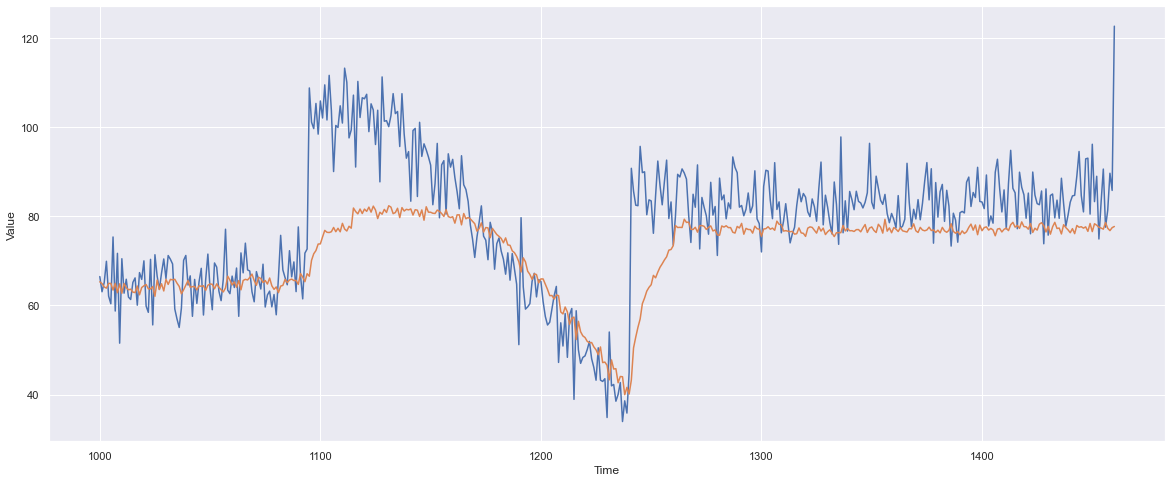

In [22]:
plt.figure(figsize=(20,8))
plotSeries(timeValid, xValid)
plotSeries(timeValid, results)

In [23]:
score = tf.keras.metrics.mean_absolute_error(xValid, results).numpy()
print(score)

8.5838585


## Model - Double Layer 

In [37]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

### Tune Learning Rate

In [26]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [27]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [28]:
history = model.fit(trainSet, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
31/31 [==============================] - 5s 19ms/step - loss: 27.6333 - mae: 28.1330
Epoch 2/500
31/31 [==============================] - 1s 19ms/step - loss: 26.7543 - mae: 27.2527
Epoch 3/500
31/31 [==============================] - 1s 18ms/step - loss: 25.7032 - mae: 26.2022
Epoch 4/500
31/31 [==============================] - 1s 19ms/step - loss: 24.5324 - mae: 25.0315
Epoch 5/500
31/31 [==============================] - 1s 19ms/step - loss: 23.2463 - mae: 23.7440
Epoch 6/500
31/31 [==============================] - 1s 19ms/step - loss: 21.8281 - mae: 22.3258
Epoch 7/500
31/31 [==============================] - 1s 20ms/step - loss: 20.3106 - mae: 20.8056
Epoch 8/500
31/31 [==============================] - 1s 20ms/step - loss: 18.7713 - mae: 19.2617
Epoch 9/500
31/31 [==============================] - 1s 19ms/step - loss: 17.3271 - mae: 17.8211
Epoch 10/500
31/31 [==============================] - 1s 19ms/step - loss: 16.0140 - mae: 16.5019
Epoch 11/500
31/31 [=========

31/31 [==============================] - 1s 18ms/step - loss: 7.0755 - mae: 7.5616
Epoch 86/500
31/31 [==============================] - 1s 19ms/step - loss: 5.9904 - mae: 6.4751
Epoch 87/500
31/31 [==============================] - 1s 19ms/step - loss: 9.1410 - mae: 9.6307
Epoch 88/500
31/31 [==============================] - 1s 18ms/step - loss: 9.1038 - mae: 9.5940
Epoch 89/500
31/31 [==============================] - 1s 18ms/step - loss: 9.1243 - mae: 9.6146
Epoch 90/500
31/31 [==============================] - 1s 19ms/step - loss: 6.5691 - mae: 7.0544
Epoch 91/500
31/31 [==============================] - 1s 19ms/step - loss: 9.5110 - mae: 10.0010
Epoch 92/500
31/31 [==============================] - 1s 19ms/step - loss: 7.7466 - mae: 8.2350
Epoch 93/500
31/31 [==============================] - 1s 18ms/step - loss: 9.5086 - mae: 9.9971
Epoch 94/500
31/31 [==============================] - 1s 19ms/step - loss: 7.6693 - mae: 8.1589
Epoch 95/500
31/31 [==============================] 

(1e-08, 0.0001, 0.0, 30.0)

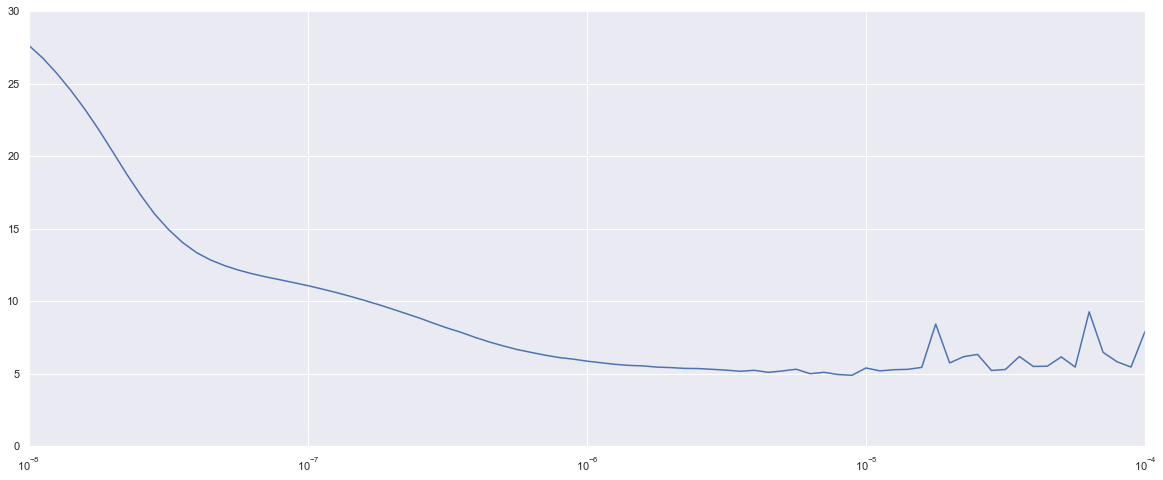

In [29]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [44]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [46]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

Epoch 1/500
31/31 [==============================] - 5s 20ms/step - loss: 15.6548 - mae: 16.1469
Epoch 2/500
31/31 [==============================] - 1s 19ms/step - loss: 7.3301 - mae: 7.8124
Epoch 3/500
31/31 [==============================] - 1s 19ms/step - loss: 6.5184 - mae: 6.9966
Epoch 4/500
31/31 [==============================] - 1s 19ms/step - loss: 6.1546 - mae: 6.6350
Epoch 5/500
31/31 [==============================] - 1s 19ms/step - loss: 6.0141 - mae: 6.4943
Epoch 6/500
31/31 [==============================] - 1s 19ms/step - loss: 6.3374 - mae: 6.8185
Epoch 7/500
31/31 [==============================] - 1s 19ms/step - loss: 5.9094 - mae: 6.3941
Epoch 8/500
31/31 [==============================] - 1s 19ms/step - loss: 5.8201 - mae: 6.3052
Epoch 9/500
31/31 [==============================] - 1s 18ms/step - loss: 5.2858 - mae: 5.7655
Epoch 10/500
31/31 [==============================] - 1s 19ms/step - loss: 5.0784 - mae: 5.5595
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 1s 19ms/step - loss: 5.0544 - mae: 5.5337
Epoch 86/500
31/31 [==============================] - 1s 19ms/step - loss: 4.8836 - mae: 5.3636
Epoch 87/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5978 - mae: 5.0788
Epoch 88/500
31/31 [==============================] - 1s 18ms/step - loss: 4.4624 - mae: 4.9408
Epoch 89/500
31/31 [==============================] - 1s 19ms/step - loss: 4.4617 - mae: 4.9387
Epoch 90/500
31/31 [==============================] - 1s 18ms/step - loss: 4.7167 - mae: 5.1933
Epoch 91/500
31/31 [==============================] - 1s 18ms/step - loss: 5.2666 - mae: 5.7499
Epoch 92/500
31/31 [==============================] - 1s 19ms/step - loss: 4.7239 - mae: 5.2021
Epoch 93/500
31/31 [==============================] - 1s 20ms/step - loss: 4.4514 - mae: 4.9280
Epoch 94/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5654 - mae: 5.0437
Epoch 95/500
31/31 [==============================] -

Epoch 169/500
31/31 [==============================] - 1s 19ms/step - loss: 4.6431 - mae: 5.1195
Epoch 170/500
31/31 [==============================] - 1s 19ms/step - loss: 4.3897 - mae: 4.8631
Epoch 171/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5763 - mae: 5.0574
Epoch 172/500
31/31 [==============================] - 1s 19ms/step - loss: 4.4106 - mae: 4.8920
Epoch 173/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5652 - mae: 5.0424
Epoch 174/500
31/31 [==============================] - 1s 19ms/step - loss: 4.4364 - mae: 4.9126
Epoch 175/500
31/31 [==============================] - 1s 19ms/step - loss: 4.3661 - mae: 4.8419
Epoch 176/500
31/31 [==============================] - 1s 19ms/step - loss: 4.4127 - mae: 4.8880
Epoch 177/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5023 - mae: 4.9806
Epoch 178/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5835 - mae: 5.0627
Epoch 179/500
31/31 [=========

In [47]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

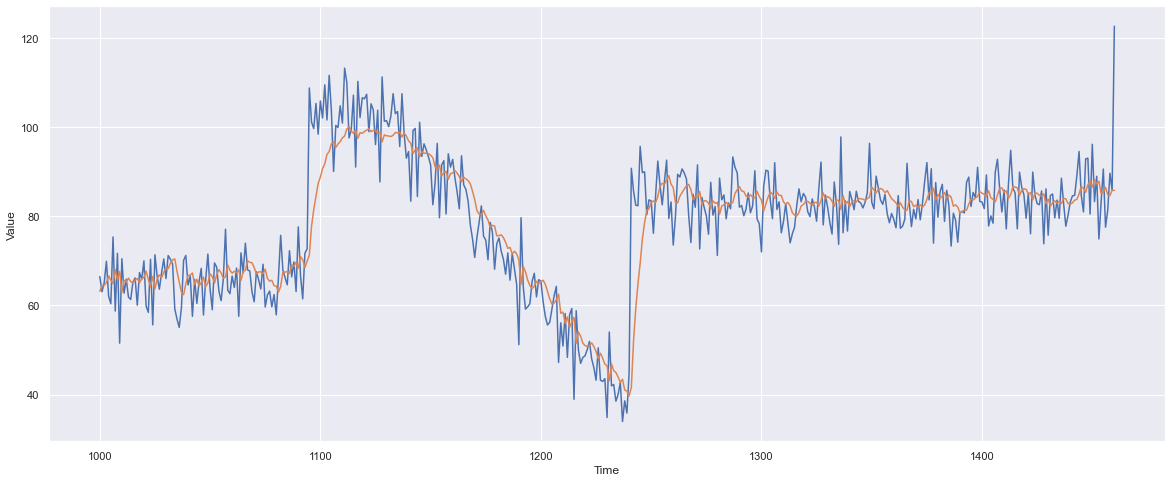

In [48]:
plt.figure(figsize=(20,8))
plotSeries(timeValid, xValid)
plotSeries(timeValid, results)

In [49]:
score = tf.keras.metrics.mean_absolute_error(xValid, results).numpy()
print(score)

5.382572
